# 목표: 행마다 병목 찾고 영향 보기

- 병목 표시: 각 시점에서 **가장 긴 Queue**를 `_bneck`으로 지정
- 불량 점수 만들기: `_quality_reject_proxy`(0~1) 생성
- 영향 분석: **병목 one-hot**으로 리드타임·생산·품질(프록시) **조정효과** 계산
- 예측: (분류) **현재/다음 시점 병목 위치**, (회귀) **병목 Queue 크기** 예측
- 병목만 바꿔보기: 다른 조건은 같게 두고 **병목만 교체**했을 때 평균 변화(Δ)
- What-if: **전체를 특정 병목으로 가정**했을 때 평균 변화 JSON
- 요약: 생성 파일/지표를 `SUMMARY.json`에 정리

**권장 실행 순서**
0 → 1 → 2 → 3 → 7a → 7 → 4 → 4b → 5 → 6 → 8 → 9  
(※ 7a를 안 돌려도 4에서 품질 프록시 자동 생성)

**한 줄 기억 포인트**
- 0: 준비
- 1–2–3: 데이터 로드 → 타깃 만들기 → 병목 라벨
- 7a–7: 품질 프록시 만들고 병목별 차이 확인
- 4–5–6: 병목 **조정효과** 수치화 → 병목만 바꿔 비교 → JSON 요약
- 4b: **현재/다음 병목**과 **Queue 크기** 예측
- 9: 결과물 색인(SUMMARY)

In [1]:
%matplotlib inline

## 0) 준비 셀(유틸/환경)
- 출력 폴더 및 타임스탬프 생성, 저장 유틸(`save_csv/json`, `list_saved`)
- 경량 전처리(열 패턴/행 샘플링), 공통 모델/피처 빌더/시뮬 유틸
- (옵션) SKU별 MUSD 파생 피처 도구
**쉽게 말해:** 다음 셀들이 편하게 쓰는 **도구 상자**를 깔아둡니다.

In [2]:
# ============================================
# 0) 드롭인 패치 셀 (경량 모드, 파일 로깅, 공통 유틸)
# ============================================
import os, re, gc, json, math, warnings
import numpy as np
import pandas as pd
from collections import defaultdict
from typing import Dict, List, Tuple, Optional
from datetime import datetime

# ---- 글로벌 스위치 ----
SPEED_MODE         = True
ENABLE_PLOTS       = True   # ← 시각화 저장 ON
ROW_SAMPLE_MAX     = 250_000
COL_KEEP_PAT       = r"(?:_Queue|_Util|^c_Cell|^c_TotalProducts$|^SKU\d+_(?:VA|Wait|Transport|LeadTime|Total))"
TOP_SKU_K          = 4
MAX_BNECK_ONEHOT   = 20
RIDGE_TEST_SIZE    = 0.25
RF_ESTIMATORS      = 60
RF_MAX_DEPTH       = 12
RF_NJOBS           = -1

# (누수 위험) 시간 타깃 관련은 기본 False 유지
INCLUDE_MUSD_IN_LT = False
INCLUDE_MUSD_IN_PR = False
WHATIF_SCENARIOS   = {}

# (옵션) MUSD 파생피처 기본 ON
MUSD_ON_START = True
MUSD: Dict[str, Dict[str, Dict[str, float]]] = {
    "SKU1": {
        "mu": {"BL":900.0, "PR":5.0, "AS":25.0, "PA":5400.0, "QL":55.0},
        "sd": {"BL":30.0,  "PR":0.1, "AS":0.1,  "PA":0.0,    "QL":2.04},
    }
}
REPLICATE_TO_OTHERS = True

def add_musd_features(df_: pd.DataFrame, sku_ids_: List[str]) -> List[str]:
    created = []
    for sid in sku_ids_:
        key = f"SKU{sid}"
        if key not in MUSD and REPLICATE_TO_OTHERS and "SKU1" in MUSD:
            MUSD[key] = MUSD["SKU1"]
        if key not in MUSD:
            continue
        mu = MUSD[key]["mu"]; sd = MUSD[key]["sd"]
        mu_sum = mu["BL"] + mu["PR"] + mu["AS"] + mu["PA"] + mu["QL"]
        S_var  = sd["BL"]**2 + sd["PR"]**2 + sd["AS"]**2 + sd["QL"]**2
        S_std  = math.sqrt(S_var) if S_var > 0 else 1.0
        base = f"SKU{sid}"
        va_col = next((base+s for s in ["_VA_Time_sec","_VA_Time","_VA"] if (base+s) in df_.columns), None)
        VA = pd.to_numeric(df_[va_col], errors="coerce").fillna(0.0) if va_col else pd.Series(0.0, index=df_.index)
        dev_col = f"{base}_VA_dev"; z_col = f"{base}_VA_z"
        df_[dev_col] = (VA - mu_sum).astype("float32")
        df_[z_col]   = ((VA - mu_sum)/S_std).astype("float32")
        created += [dev_col, z_col]
    return created

pd.set_option('future.no_silent_downcasting', True)

def _compute_outdir():
    now = datetime.now()
    stamp = now.strftime("%m%d%H")
    base = os.path.join("./outputs", stamp)
    if os.path.exists(base):
        stamp = now.strftime("%m%d%H%M")
        base = os.path.join("./outputs", stamp)
    os.makedirs(base, exist_ok=True)
    return stamp, base

RUN_STAMP, DEFAULT_OUT_DIR = _compute_outdir()

# ---- 파일 로깅 유틸 ----
SAVED_FILES = defaultdict(list)
def _ensure_outdir(path):
    os.makedirs(os.path.dirname(path), exist_ok=True); return path
def register_output(path, cell_tag=None, note=None):
    path = os.path.abspath(path); rel = os.path.relpath(path, start='.')
    if cell_tag is None: cell_tag = "_misc"
    SAVED_FILES[cell_tag].append(rel)
    if note and SPEED_MODE: print(f"[SAVED] {rel} ({note})")
    return rel
def save_csv(df, filename, cell_tag):
    base = globals().get("OUT_DIR", DEFAULT_OUT_DIR)
    path = filename if os.path.isabs(filename) else os.path.join(base, filename)
    _ensure_outdir(path); df.to_csv(path, index=False)
    return register_output(path, cell_tag, "csv")
def save_json(obj, filename, cell_tag):
    base = globals().get("OUT_DIR", DEFAULT_OUT_DIR)
    path = filename if os.path.isabs(filename) else os.path.join(base, filename)
    _ensure_outdir(path)
    with open(path, 'w', encoding='utf-8') as f: json.dump(obj, f, ensure_ascii=False, indent=2)
    return register_output(path, cell_tag, "json")
def list_saved(cell_tag=None):
    if cell_tag:
        files = SAVED_FILES.get(cell_tag, [])
        print(f"\n[Saved files in {cell_tag}]"); print(" - " + "\n - ".join(files) if files else " (none)")
    else:
        print("\n[All saved files]")
        for tag, files in SAVED_FILES.items():
            print(f" {tag}:"); [print("   -", p) for p in files]
def begin_cell(tag): SAVED_FILES[tag].clear()
def _speed_log(*a):
    if SPEED_MODE: print(*a)
def savefig(path: str, cell_tag=None, show_inline=True):
    if not ENABLE_PLOTS: 
        return
    import matplotlib.pyplot as plt
    try:
        plt.tight_layout()
    except Exception:
        pass
    _ensure_outdir(path)
    plt.savefig(path, bbox_inches="tight", dpi=140)
    if show_inline:
        plt.show()            # ← 화면에 출력
    plt.close()               # ← 메모리 정리
    gc.collect()
    register_output(path, cell_tag or "_fig", "figure")

def to_numeric_df(d: pd.DataFrame) -> pd.DataFrame:
    for c in d.columns: d.loc[:, c] = pd.to_numeric(d[c], errors="coerce", downcast="float")
    return d.fillna(0.0).infer_objects(copy=False)

def _apply_df_speed_filters(df: pd.DataFrame) -> pd.DataFrame:
    if not SPEED_MODE: return to_numeric_df(df)
    if COL_KEEP_PAT:
        keep_re = re.compile(COL_KEEP_PAT, re.IGNORECASE)
        keep_cols = [c for c in df.columns if keep_re.search(c)]
        for must in ["Time_Now"]:
            if must in df.columns and must not in keep_cols:  # noqa: E713
                keep_cols.append(must)
        df = df[keep_cols]; _speed_log(f"[SPEED] kept {len(keep_cols)} columns by pattern.")
    if ROW_SAMPLE_MAX and len(df) > ROW_SAMPLE_MAX:
        df = df.sample(ROW_SAMPLE_MAX, random_state=42).sort_index()
        _speed_log(f"[SPEED] row-sampled to {ROW_SAMPLE_MAX} rows.")
    return to_numeric_df(df)

# ---- 모델 공통 ----
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def metrics_dict(y_true, y_pred) -> dict:
    mae  = float(mean_absolute_error(y_true, y_pred))
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    r2   = float(r2_score(y_true, y_pred))
    return {"MAE": round(mae,3), "RMSE": round(rmse,3), "R2": round(r2,4)}
def train_ridge(X, y, alpha=1.0, random_state=42, test_size=None):
    from sklearn.linear_model import Ridge
    if test_size is None: test_size = RIDGE_TEST_SIZE if SPEED_MODE else 0.3
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    reg = Ridge(alpha=alpha, random_state=random_state); reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test); m = metrics_dict(y_test, y_pred)
    coef = pd.Series(reg.coef_, index=X.columns)
    std_x = X_test.std(axis=0).replace(0, np.nan); std_y = np.std(y_test) if np.std(y_test)>0 else np.nan
    beta_std = coef * (std_x / std_y)
    return reg, (X_train, X_test, y_train, y_test), m, coef.sort_values(ascending=False), beta_std.sort_values(ascending=False)

# ---- 피처/병목 One-Hot ----
time_like_regex = re.compile(r'(?:_Time|_sec|_LeadTime|_Total|_VA_(?:dev|z))', re.IGNORECASE)

def _add_bneck_onehot(df_, X, top_bneck_list=None, max_bneck=None):
    if max_bneck is None: max_bneck = MAX_BNECK_ONEHOT
    if "_bneck" not in df_.columns: return X, []
    b_series = df_["_bneck"].astype(str)
    if top_bneck_list is not None: b_series = b_series.where(b_series.isin(top_bneck_list), "Other")
    topN = b_series.value_counts().nlargest(max_bneck).index
    b_series = b_series.where(b_series.isin(topN), "Other")
    D = pd.get_dummies(b_series, prefix="BNECK", dtype="float32")
    X = pd.concat([X, D], axis=1)
    return X, [c for c in D.columns]

def build_features_for_leadtime(df_, exclude_cols=[], add_bneck_onehot=True, top_bneck_list=None, max_bneck=None):
    cols = [c for c in df_.columns if c not in exclude_cols and c != "Time_Now" and not time_like_regex.search(c)]
    X = to_numeric_df(df_[cols]) if cols else pd.DataFrame(index=df_.index)
    b_cols = []
    if add_bneck_onehot: X, b_cols = _add_bneck_onehot(df_, X, top_bneck_list, max_bneck)
    return X, b_cols

def build_features_for_production(df_, exclude_cols=[], add_bneck_onehot=True, top_bneck_list=None, max_bneck=None):
    cols = [c for c in df_.columns if c not in exclude_cols and c != "Time_Now" and not c.startswith("c_Cell") and c != "c_TotalProducts"]
    X = to_numeric_df(df_[cols]) if cols else pd.DataFrame(index=df_.index)
    b_cols = []
    if add_bneck_onehot: X, b_cols = _add_bneck_onehot(df_, X, top_bneck_list, max_bneck)
    return X, b_cols

def limit_top_k_skus(sku_ids, sku_targets, k=TOP_SKU_K):
    if not SPEED_MODE or not k or k >= len(sku_ids): return sku_ids
    sums = []
    for sid in sku_ids:
        pr = sku_targets[sid]["production"]
        sums.append((sid, float(np.nansum(pr.values)) if hasattr(pr, "values") else float(np.nansum(pr))))
    sums = sorted(sums, key=lambda x: x[1], reverse=True)
    top = [sid for sid, _ in sums[:k]]
    _speed_log(f"[SPEED] limit SKUs → top {k}: {top}")
    return top

def align_X_for_model(X_built: pd.DataFrame, trained_feats: List[str]) -> pd.DataFrame:
    return X_built.reindex(columns=trained_feats, fill_value=0.0)

def simulate_bneck_mean(model, X_base: pd.DataFrame, bneck_cols: List[str], target_bneck_col: str) -> float:
    X_sim = X_base.copy()
    for c in bneck_cols:
        if c not in X_sim.columns:
            X_sim[c] = 0.0
        else:
            X_sim[c] = 0.0
    if target_bneck_col not in X_sim.columns:
        X_sim[target_bneck_col] = 0.0
    X_sim[target_bneck_col] = 1.0
    return float(model.predict(X_sim).mean())

## 1) 데이터 로드 & 가벼운 전처리
- CSV를 읽고, 필요한 열만 남기고 숫자형으로 정리
- 샘플 행/열 미리보기 출력
**쉽게 말해:** 데이터를 **가볍게 들고 오는 단계**입니다.

In [3]:
# ============================================
# 1) 설정 · 로드
# ============================================
begin_cell("cell1")

import os, re, json, math, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict, List, Tuple, Optional
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge

CSV_PATH = "./Final Results Extended.csv"   # 필요시 변경

OUT_DIR = DEFAULT_OUT_DIR
print(f"[RUN_STAMP] {RUN_STAMP}")
print(f"[OUT_DIR]   {OUT_DIR}")
os.makedirs(OUT_DIR, exist_ok=True)

pd.set_option("display.max_columns", 160)
pd.set_option("display.width", 160)

df = pd.read_csv(CSV_PATH, low_memory=False)
df = _apply_df_speed_filters(df)
print("=== Dataset shape ===", df.shape)
display(df.head(3))

def topk(s: pd.Series, k=20): return s.head(k) if len(s) > k else s
def ensure_dir(path: str): os.makedirs(os.path.dirname(path), exist_ok=True); return path

print("\n[설명] 이 데이터는 이후 모든 셀의 공통 입력으로 사용됩니다.")
list_saved("cell1")

[RUN_STAMP] 08242015
[OUT_DIR]   ./outputs\08242015
[SPEED] kept 66 columns by pattern.
=== Dataset shape === (132676, 66)


,Blanking_Util,Blanking_SKU1_Queue,Blanking_SKU2_Queue,Blanking_SKU3_Queue,Blanking_SKU4_Queue,Press1_Util,Press2_Util,Press3_Util,Press4_Util,Press1_Queue,Press2_Queue,Press3_Queue,Press4_Queue,Cell1_Util,Cell2_Util,Cell3_Util,Cell4_Util,Cell1_Queue,Cell2_Queue,Cell3_Queue,Cell4_Queue,Warehouse1_Queue,Warehouse_2_Queue,Warehouse_3_Queue,Warehouse_4_Queue,c_Cell1_SKU1,c_Cell1__SKU2,c_Cell1__SKU3,c_Cell1__SKU4,c_Cell2__SKU1,c_Cell2__SKU2,c_Cell2__SKU3,c_Cell2__SKU4,c_Cell3__SKU1,c_Cell3__SKU2,c_Cell3__SKU3,c_Cell3__SKU4,c_Cell4__SKU1,c_Cell4__SKU2,c_Cell4__SKU3,c_Cell4__SKU4,Paint1_Util,Paint2_Util,Quality_Util,Paint1_Queue,Paint2_Queue,Quality_Queue,Forklift_Util,Forklift_Blanking_Queue,Forklift_Press_Queue,Forklift_Assembly_Queue,c_TotalProducts,SKU1_VA_Time,SKU1_Transport_Time,SKU1_Wait_Time,SKU2_VA_Time,SKU2_Transport_Time,SKU2_Wait_Time,SKU3_VA_Time,SKU3_Transport_Time,SKU3_Wait_Time,SKU4_VA_Time,SKU4_Transport_Time,SKU4_Wait_Time,Blanking_Queue,Time_Now
0,0.846367,0.045715,0.056373,0.055737,0.035849,0.410297,0.434561,0.481388,0.399992,56.540291,65.273788,52.970764,47.964825,0.848870,0.673814,0.705012,0.819405,0.0,0.0,0.0,0.0,98.155571,19.580276,77.580864,75.124985,13967.0,10867.0,0.0,4382.0,0.0,2851.0,0.0,4334.0,0.0,903.0,4707.0,0.0,0.0,0.0,11743.0,4934.0,0.472565,0.504126,0.432738,0.0,0.0,47.361618,0.606002,157.256744,142.123962,137.454849,54377.0,1.525651,0.536810,0.587305,1.522853,0.532394,0.441645,1.525071,0.537617,0.453650,1.523338,0.536243,0.473453,58.361450,24
1,0.851097,0.051937,0.052934,0.038512,0.042248,0.455471,0.454445,0.387975,0.442986,74.772820,52.530064,49.303143,59.119987,0.876750,0.660415,0.629526,0.803448,0.0,0.0,0.0,0.0,162.632370,18.164795,64.827576,69.374908,15071.0,11180.0,0.0,3615.0,0.0,2932.0,0.0,4125.0,0.0,1346.0,3852.0,0.0,0.0,0.0,9556.0,7484.0,0.482683,0.501912,0.436583,0.0,0.0,48.266911,0.599976,166.488724,142.113663,140.757584,54857.0,1.525665,0.534195,0.684177,1.522836,0.535767,0.401993,1.524986,0.536764,0.473677,1.523344,0.534992,0.464380,62.830601,24
2,0.846115,0.052210,0.047499,0.043181,0.040979,0.496717,0.450816,0.417308,0.352829,67.283035,72.901070,39.198517,33.994083,0.895845,0.660288,0.654895,0.766823,0.0,0.0,0.0,0.0,335.401550,20.369415,46.120110,71.720192,16603.0,11042.0,0.0,2260.0,0.0,2904.0,0.0,4149.0,0.0,1198.0,4139.0,0.0,0.0,0.0,10282.0,5575.0,0.476897,0.492906,0.429997,0.0,0.0,48.906418,0.576669,159.188507,148.427689,142.653366,54052.0,1.525644,0.535403,0.898331,1.522821,0.535631,0.427815,1.525064,0.535925,0.424090,1.523403,0.535077,0.475330,59.365868,24



[설명] 이 데이터는 이후 모든 셀의 공통 입력으로 사용됩니다.

[Saved files in cell1]
 (none)


## 2) 컬럼 인식 · SKU 타깃 · 통합 리드타임
- Queue/Util/Cell 열 묶음 탐지, SKU 목록 추출
- SKU별 리드타임(직접/합성), 생산량 합계, 전체 가중 리드타임 계산
**쉽게 말해:** SKU별 **걸린 시간**과 **얼마 만들었는지**를 뽑고, 전체 **평균 시간**을 만듭니다.

In [4]:
# ============================================
# 2) 컬럼 인식 · SKU 타깃 · 통합 리드타임 계산
# ============================================
begin_cell("cell2")
import matplotlib.pyplot as plt

queue_cols = [c for c in df.columns if c.endswith("_Queue")]
util_cols  = [c for c in df.columns if c.endswith("_Util")]
cycle_cols = [c for c in df.columns if c.startswith("c_Cycle")]
cell_cols  = [c for c in df.columns if c.startswith("c_Cell")]

print("\n=== Column groups ===")
print(f"Queue cols  ({len(queue_cols)}): {queue_cols[:10]}{' ...' if len(queue_cols)>10 else ''}")
print(f"Util cols   ({len(util_cols)}):  {util_cols[:10]}{' ...' if len(util_cols)>10 else ''}")
print(f"Cycle cols  ({len(cycle_cols)}): {cycle_cols[:10]}")
print(f"Cell cols   ({len(cell_cols)}):  {cell_cols[:10]}{' ...' if len(cell_cols)>10 else ''}")

# SKU 자동 탐지
sku_ids = sorted({re.findall(r"SKU(\d+)_", c)[0] for c in df.columns if re.findall(r"SKU(\d+)_", c)})
print("\n=== Detected SKUs ===", sku_ids)

LT_PATTERNS = dict(
    VA=["_VA_Time_sec", "_VA_Time", "_VA"],
    WAIT=["_Wait_Time_sec", "_Wait_Time", "_Wait"],
    LIFT=["_Transport_Time_sec", "_Transport_Time", "_Transport", "_Lift"],
    TOTAL=["_Total_sec", "_LeadTime_sec", "_LeadTime"]
)
def find_first_existing(base: str, suffixes: List[str]) -> Optional[str]:
    for s in suffixes:
        col = base + s
        if col in df.columns:
            return col
    return None

sku_targets = {}
for sid in sku_ids:
    base = f"SKU{sid}"
    col_VA   = find_first_existing(base, LT_PATTERNS["VA"])
    col_WAIT = find_first_existing(base, LT_PATTERNS["WAIT"])
    col_LIFT = find_first_existing(base, LT_PATTERNS["LIFT"])
    col_TOT  = find_first_existing(base, LT_PATTERNS["TOTAL"])

    if col_TOT:
        lt_series = pd.to_numeric(df[col_TOT], errors="coerce").fillna(0.0).astype("float32")
        lt_name, lt_method = col_TOT, "TOTAL_col"
    else:
        VA   = pd.to_numeric(df[col_VA],   errors="coerce").fillna(0.0).astype("float32") if col_VA   else 0.0
        WAIT = pd.to_numeric(df[col_WAIT], errors="coerce").fillna(0.0).astype("float32") if col_WAIT else 0.0
        LIFT = pd.to_numeric(df[col_LIFT], errors="coerce").fillna(0.0).astype("float32") if col_LIFT else 0.0
        lt_series = pd.Series(VA, index=df.index) + pd.Series(WAIT, index=df.index) + pd.Series(LIFT, index=df.index)
        lt_series = lt_series.astype("float32")
        lt_name, lt_method = f"{base}_LeadTime_composed", "VA+WAIT+LIFT"

    cell_cols_sku = [c for c in cell_cols if re.search(fr"__SKU{sid}\b", c)]
    if cell_cols_sku:
        prod_series = to_numeric_df(df[cell_cols_sku]).sum(axis=1).astype("float32")
        prod_name   = f"Total_SKU{sid}"
    else:
        prod_series = pd.Series(0.0, index=df.index, dtype="float32")
        prod_name   = f"Total_SKU{sid}_zeros"

    sku_targets[sid] = dict(
        lead_time=lt_series, lead_time_name=lt_name, lead_time_method=lt_method,
        production=prod_series, production_name=prod_name, cell_cols=cell_cols_sku
    )

# 통합 타깃: 가중 리드타임
if "c_TotalProducts" in df.columns:
    total_prod = pd.to_numeric(df["c_TotalProducts"], errors="coerce").fillna(0.0).astype("float32")
else:
    total_prod = to_numeric_df(df[cell_cols]).sum(axis=1).astype("float32")

N = len(df)
numerator = np.zeros(N, dtype=np.float32)
weights   = np.zeros(N, dtype=np.float32)
sum_lt    = np.zeros(N, dtype=np.float32)
k_count   = 0
for sid in sku_ids:
    lt = sku_targets[sid]["lead_time"].values
    pr = sku_targets[sid]["production"].values
    numerator += lt * pr; weights += pr; sum_lt += lt; k_count += 1
fallback_mean = (sum_lt / max(k_count, 1)).astype("float32")
with np.errstate(divide='ignore', invalid='ignore'):
    weighted_lt = np.where(weights > 0.0, numerator / weights, fallback_mean)
agg_lead_time = pd.Series(weighted_lt, index=df.index, name="Agg_LeadTime_weighted").astype("float32")

del numerator, weights, sum_lt; gc.collect()

if MUSD_ON_START:
    musd_cols = add_musd_features(df, sku_ids)
    print(f"[MUSD] 파생 {len(musd_cols)}개 생성(예: {musd_cols[:min(6, len(musd_cols))]})")

# 간단 요약 문장
print(f"[요약] SKU 수={len(sku_ids)}, 통합 리드타임(series) 생성 완료, 총 생산량 열 존재={ 'c_TotalProducts' in df.columns }")
list_saved("cell2")


=== Column groups ===
Queue cols  (23): ['Blanking_SKU1_Queue', 'Blanking_SKU2_Queue', 'Blanking_SKU3_Queue', 'Blanking_SKU4_Queue', 'Press1_Queue', 'Press2_Queue', 'Press3_Queue', 'Press4_Queue', 'Cell1_Queue', 'Cell2_Queue'] ...
Util cols   (13):  ['Blanking_Util', 'Press1_Util', 'Press2_Util', 'Press3_Util', 'Press4_Util', 'Cell1_Util', 'Cell2_Util', 'Cell3_Util', 'Cell4_Util', 'Paint1_Util'] ...
Cycle cols  (0): []
Cell cols   (16):  ['c_Cell1_SKU1', 'c_Cell1__SKU2', 'c_Cell1__SKU3', 'c_Cell1__SKU4', 'c_Cell2__SKU1', 'c_Cell2__SKU2', 'c_Cell2__SKU3', 'c_Cell2__SKU4', 'c_Cell3__SKU1', 'c_Cell3__SKU2'] ...

=== Detected SKUs === ['1', '2', '3', '4']
[MUSD] 파생 8개 생성(예: ['SKU1_VA_dev', 'SKU1_VA_z', 'SKU2_VA_dev', 'SKU2_VA_z', 'SKU3_VA_dev', 'SKU3_VA_z'])
[요약] SKU 수=4, 통합 리드타임(series) 생성 완료, 총 생산량 열 존재=True

[Saved files in cell2]
 (none)


## 3) 병목 라벨링 · 요약표 · 상위 병목 선정
- 각 시점 **최대 Queue**를 `_bneck`으로 라벨링
- 병목별 **빈도/평균 타깃** 요약, 상위 병목 리스트(`TOP_BNECKS`) 도출
- (그림) 상위 병목 빈도 Top10 막대그래프 저장
**쉽게 말해:** **제일 막힌 공정**이 어디였는지 찍고, **자주 막힌 곳**을 봅니다.

[SAVED] outputs\08242015\bottleneck_totalProduction.csv (csv)
[SAVED] outputs\08242015\bottleneck_aggLeadTime.csv (csv)

=== 생산량 기준 병목 빈도 (상위) ===


,bneck,top1_count,mean_target,std_target,target_name
0,Warehouse1_Queue,77631,54858.582031,1095.462769,TotalProduction
1,Forklift_Blanking_Queue,53681,54578.960938,1087.814575,TotalProduction
2,Warehouse_3_Queue,1307,55135.089844,1061.024292,TotalProduction
3,Warehouse_4_Queue,36,56690.417969,646.384399,TotalProduction
4,Forklift_Press_Queue,9,54510.332031,932.098145,TotalProduction
5,Press4_Queue,6,55440.832031,665.971619,TotalProduction
6,Press2_Queue,5,55408.398438,477.534607,TotalProduction
7,Blanking_SKU3_Queue,1,0.000000,NaN,TotalProduction



=== 리드타임 기준 병목 빈도 (상위) ===


,bneck,top1_count,mean_target,std_target,target_name
0,Warehouse1_Queue,77631,2.513333,0.023924,AggLeadTime
1,Forklift_Blanking_Queue,53681,2.505023,0.017277,AggLeadTime
2,Warehouse_3_Queue,1307,2.577764,0.035883,AggLeadTime
3,Warehouse_4_Queue,36,2.568670,0.025048,AggLeadTime
4,Forklift_Press_Queue,9,2.501076,0.016981,AggLeadTime
5,Press4_Queue,6,2.546885,0.043715,AggLeadTime
6,Press2_Queue,5,2.540109,0.018334,AggLeadTime
7,Blanking_SKU3_Queue,1,0.000000,NaN,AggLeadTime


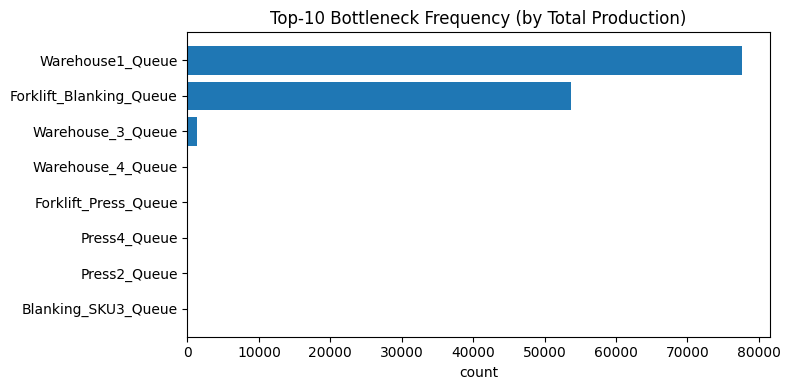

[SAVED] outputs\08242015\plot_bottleneck_frequency_top10.png (figure)
[FIG] 저장: ./outputs\08242015\plot_bottleneck_frequency_top10.png
[요약] 상위 병목 후보=['Warehouse1_Queue', 'Forklift_Blanking_Queue', 'Warehouse_3_Queue', 'Warehouse_4_Queue', 'Forklift_Press_Queue'] ...

[Saved files in cell3]
 - outputs\08242015\bottleneck_totalProduction.csv
 - outputs\08242015\bottleneck_aggLeadTime.csv
 - outputs\08242015\plot_bottleneck_frequency_top10.png


In [5]:
# ============================================
# 3) 병목 라벨링 · 요약표(생산/리드타임) · 상위 병목 선정
# ============================================
begin_cell("cell3")
import matplotlib.pyplot as plt

Q = to_numeric_df(df[[c for c in df.columns if c.endswith("_Queue")]])
if Q.shape[1] == 0: raise ValueError("Queue 계열 컬럼이 없습니다.")
df["_bneck"] = Q.idxmax(axis=1)

def compute_bneck_stats(target: pd.Series, name: str, out_csv: str):
    tmp = pd.DataFrame({"bneck": df["_bneck"].astype("category"), "val": target.astype("float32")})
    stats = tmp.groupby("bneck", observed=False).agg(
        top1_count=("bneck", "count"),
        mean_target=("val", "mean"),
        std_target=("val", "std")
    ).sort_values("top1_count", ascending=False).reset_index()
    stats["target_name"] = name
    save_csv(stats, out_csv, cell_tag="cell3"); return stats

bneck_total_prod = compute_bneck_stats(total_prod, "TotalProduction", "bottleneck_totalProduction.csv")
bneck_agg_lt     = compute_bneck_stats(agg_lead_time, "AggLeadTime", "bottleneck_aggLeadTime.csv")

print("\n=== 생산량 기준 병목 빈도 (상위) ==="); display(bneck_total_prod.head(10))
print("\n=== 리드타임 기준 병목 빈도 (상위) ==="); display(bneck_agg_lt.head(10))

TOP_BNECKS = list(bneck_total_prod["bneck"].head(8).values)

# (그림) 상위 병목 빈도 Top10
if ENABLE_PLOTS:
    figpath = os.path.join(OUT_DIR, "plot_bottleneck_frequency_top10.png")
    plt.figure(figsize=(8,4))
    tmp = bneck_total_prod.head(10)
    plt.barh(tmp["bneck"][::-1], tmp["top1_count"][::-1])
    plt.xlabel("count"); plt.title("Top-10 Bottleneck Frequency (by Total Production)")
    savefig(figpath, "cell3")
    print(f"[FIG] 저장: {figpath}")

print(f"[요약] 상위 병목 후보={TOP_BNECKS[:5]} ...")
list_saved("cell3")

## 7a) 품질 프록시 생성(_quality_reject_proxy)
- 도장/검사 부하와 산출 추이를 조합해 **불량 위험 프록시(0~1)** 생성
- (그림) 프록시 분포 히스토그램 저장
**쉽게 말해:** **불량이 늘 법한 상황**을 점수로 만듭니다.

[DEFECT PROXY] 생성 완료: {'min': 0.0, 'median': 0.5141528248786926, 'max': 1.0}


,bneck,count,mean_defect,std_defect
0,Warehouse_4_Queue,36,0.553382,0.187337
1,Press2_Queue,5,0.528022,0.216524
2,Warehouse1_Queue,77631,0.521246,0.210814
3,Warehouse_3_Queue,1307,0.504420,0.216034
4,Forklift_Blanking_Queue,53681,0.497501,0.211187
5,Forklift_Press_Queue,9,0.479962,0.117338
6,Press4_Queue,6,0.447602,0.117323
7,Blanking_SKU3_Queue,1,0.000000,NaN


[SAVED] outputs\08242015\bneck_vs_defectProxy_basic.csv (csv)


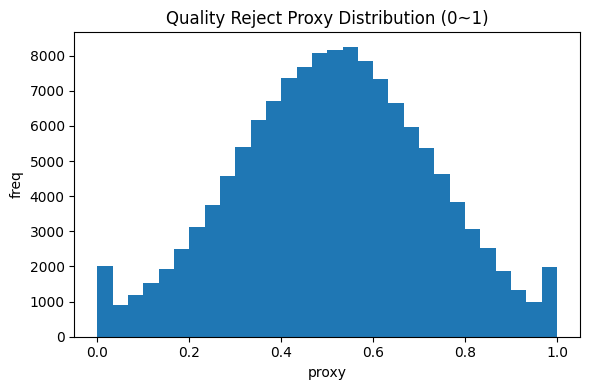

[SAVED] outputs\08242015\plot_quality_proxy_hist.png (figure)
[FIG] 저장: ./outputs\08242015\plot_quality_proxy_hist.png

[Saved files in cell7a]
 - outputs\08242015\bneck_vs_defectProxy_basic.csv
 - outputs\08242015\plot_quality_proxy_hist.png


In [6]:
# ============================================
# 7a) 품질 프록시 생성(_quality_reject_proxy)
# ============================================
begin_cell("cell7a")
import matplotlib.pyplot as plt

def _safe_col(df, name, default=0.0):
    return pd.to_numeric(df[name], errors="coerce").fillna(default).astype("float32") if name in df.columns else pd.Series(default, index=df.index, dtype="float32")

u_p1   = _safe_col(df, "Paint1_Util")
u_p2   = _safe_col(df, "Paint2_Util")
u_q    = _safe_col(df, "Quality_Util")
q_q    = _safe_col(df, "Quality_Queue")
tot    = _safe_col(df, "c_TotalProducts")

delta_final_raw = tot.diff().fillna(0.0).clip(lower=0).astype("float32")
delta_final     = delta_final_raw.rolling(window=5, min_periods=1).mean().astype("float32")

upstream_idx = (u_p1 + u_p2 + u_q).astype("float32")
quality_load = (q_q).astype("float32")
downstream_y = (delta_final).astype("float32")

def _z(x):
    mu, sd = float(np.nanmean(x)), float(np.nanstd(x))
    if not np.isfinite(sd) or sd == 0: return pd.Series(0.0, index=df.index, dtype="float32")
    return ((x - mu) / sd).astype("float32")

zu = _z(upstream_idx); zq = _z(quality_load); zy = _z(downstream_y)
raw_defect_proxy = (zu + zq - zy).astype("float32")

win = 25
proxy_smooth = raw_defect_proxy.rolling(window=win, min_periods=1).mean()
mn, mx = float(proxy_smooth.quantile(0.01)), float(proxy_smooth.quantile(0.99))
den = (mx - mn) if (mx - mn) > 1e-6 else 1.0
quality_reject_proxy = ((proxy_smooth - mn) / den).clip(0, 1).astype("float32")

df["_quality_reject_proxy"] = quality_reject_proxy
print("[DEFECT PROXY] 생성 완료:", {"min": float(quality_reject_proxy.min()), "median": float(quality_reject_proxy.median()), "max": float(quality_reject_proxy.max())})

# 병목 × 프록시 기초 통계
if "_bneck" in df.columns:
    tmp = pd.DataFrame({"bneck": df["_bneck"], "defect_proxy": df["_quality_reject_proxy"].astype("float32")})
    stats = tmp.groupby("bneck", observed=False).agg(
        count=("defect_proxy", "count"),
        mean_defect=("defect_proxy", "mean"),
        std_defect=("defect_proxy", "std")
    ).sort_values("mean_defect", ascending=False).reset_index()
    display(stats.head(15))
    save_csv(stats, "bneck_vs_defectProxy_basic.csv", "cell7a")

# (그림) 프록시 히스토그램
if ENABLE_PLOTS:
    figpath = os.path.join(OUT_DIR, "plot_quality_proxy_hist.png")
    plt.figure(figsize=(6,4))
    plt.hist(df["_quality_reject_proxy"].dropna().values, bins=30)
    plt.title("Quality Reject Proxy Distribution (0~1)")
    plt.xlabel("proxy"); plt.ylabel("freq")
    savefig(figpath, "cell7a")
    print(f"[FIG] 저장: {figpath}")

list_saved("cell7a")

## 7) 품질 프록시 심화 분석(CI)
- 병목별 프록시 평균/표준오차/95% CI/리프트 계산
- (그림) 표본≥200인 병목의 평균±CI 막대 그래프 저장
**쉽게 말해:** 어느 병목일 때 **불량 프록시가 눈에 띄게 높/낮**은지 봅니다.

[SAVED] outputs\08242015\bneck_vs_defectProxy_main_CI.csv (csv)
[SAVED] outputs\08242015\bneck_vs_defectProxy_lowCount_CI.csv (csv)

=== 병목 ↔ 불량 Proxy (표본≥200) — 전체 평균=0.511 ===


,bneck,count,mean_defect,std_defect,lift_vs_overall,rel_lift_%,ci_low,ci_high,sig_95
5,Warehouse1_Queue,77631,0.521246,0.210814,0.009774,1.910962,0.519763,0.522729,★
6,Warehouse_3_Queue,1307,0.504420,0.216034,-0.007052,-1.378685,0.492708,0.516132,
1,Forklift_Blanking_Queue,53681,0.497501,0.211187,-0.013971,-2.731488,0.495714,0.499288,★


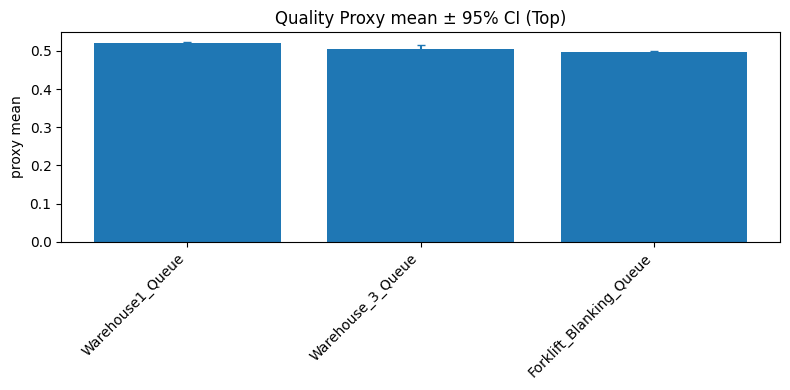

[SAVED] outputs\08242015\plot_quality_proxy_CI.png (figure)
[FIG] 저장: ./outputs\08242015\plot_quality_proxy_CI.png

=== 병목 ↔ 불량 Proxy (표본<200) — 참고용 ===


,bneck,count,mean_defect,std_defect,lift_vs_overall,rel_lift_%,ci_low,ci_high,sig_95
7,Warehouse_4_Queue,36,0.553382,0.187337,0.041910,8.194092,0.492186,0.614579,
3,Press2_Queue,5,0.528022,0.216524,0.016550,3.235831,0.338231,0.717814,
2,Forklift_Press_Queue,9,0.479962,0.117338,-0.031510,-6.160611,0.403301,0.556623,
4,Press4_Queue,6,0.447602,0.117323,-0.063870,-12.487465,0.353724,0.541480,
0,Blanking_SKU3_Queue,1,0.000000,NaN,-0.511472,-100.000000,NaN,NaN,



[Saved files in cell7]
 - outputs\08242015\bneck_vs_defectProxy_main_CI.csv
 - outputs\08242015\bneck_vs_defectProxy_lowCount_CI.csv
 - outputs\08242015\plot_quality_proxy_CI.png


In [7]:
# ============================================
# 7) 품질 프록시 심화 분석(라벨 비교 + CI)
# ============================================
begin_cell("cell7")
import matplotlib.pyplot as plt

tgt_name = "_quality_reject_proxy"
min_count = 200
overall_mean = float(df[tgt_name].mean())

tmp = pd.DataFrame({"bneck": df["_bneck"], "defect_proxy": df[tgt_name].astype("float32")})
stats = (tmp.groupby("bneck", observed=False)
           .agg(count=("defect_proxy","count"),
                mean_defect=("defect_proxy","mean"),
                std_defect=("defect_proxy","std"))
           .reset_index())
stats["se"] = stats["std_defect"]/np.sqrt(stats["count"].clip(lower=1))
stats["ci_low"]  = stats["mean_defect"] - 1.96*stats["se"]
stats["ci_high"] = stats["mean_defect"] + 1.96*stats["se"]
stats["lift_vs_overall"] = stats["mean_defect"] - overall_mean
stats["rel_lift_%"] = 100.0 * stats["lift_vs_overall"] / overall_mean
stats["z"] = (stats["mean_defect"] - overall_mean) / stats["se"].replace(0, np.nan)
stats["sig_95"] = np.where(stats["z"].abs() >= 1.96, "★", "")

stats_strong = stats[stats["count"] >= min_count].copy().sort_values(["rel_lift_%","count"], ascending=[False,False])
stats_weak   = stats[stats["count"] <  min_count].copy().sort_values(["rel_lift_%","count"], ascending=[False,False])

save_csv(stats_strong, "bneck_vs_defectProxy_main_CI.csv", "cell7")
save_csv(stats_weak,   "bneck_vs_defectProxy_lowCount_CI.csv", "cell7")

print(f"\n=== 병목 ↔ 불량 Proxy (표본≥{min_count}) — 전체 평균={overall_mean:.3f} ===")
cols_show = ["bneck","count","mean_defect","std_defect","lift_vs_overall","rel_lift_%","ci_low","ci_high","sig_95"]
display(stats_strong[cols_show].head(15))

# (그림) 표본≥200인 병목의 평균±CI
if ENABLE_PLOTS and len(stats_strong):
    import numpy as np  # ← 이 줄만 추가/수정

    figpath = os.path.join(OUT_DIR, "plot_quality_proxy_CI.png")
    plt.figure(figsize=(8,4))

    s = stats_strong.head(10).reset_index(drop=True)
    x = np.arange(len(s))

    # 막대(평균)
    mean_vals = s["mean_defect"].to_numpy()
    plt.bar(x, mean_vals)

    # 에러바(95% CI)
    yerr_arr = np.vstack([
        mean_vals - s["ci_low"].to_numpy(),
        s["ci_high"].to_numpy() - mean_vals
    ])
    plt.errorbar(x, mean_vals, yerr=yerr_arr, fmt="none", capsize=3)

    plt.xticks(x, s["bneck"], rotation=45, ha="right")
    plt.ylabel("proxy mean"); plt.title("Quality Proxy mean ± 95% CI (Top)")
    savefig(figpath, "cell7")
    print(f"[FIG] 저장: {figpath}")

if len(stats_weak):
    print(f"\n=== 병목 ↔ 불량 Proxy (표본<{min_count}) — 참고용 ===")
    display(stats_weak[cols_show].head(15))

list_saved("cell7")

## 4) 병목 효과 모델(조정효과) — Ridge
- **통제변수 + 병목 one-hot**로 리드타임/생산/품질(프록시) **조정효과** 추정
- **누수 방지:** 품질 프록시 학습 시 **프록시 구성 변수(도장/검사/산출)**를 입력에서 제외
- (그림) 각 타깃의 **병목 계수 Top10** 막대그래프
**쉽게 말해:** 다른 조건 같다고 보고, **병목이 어디냐에 따라** 지표가 얼마나 달라지는지 수치화합니다.

[SAVED] outputs\08242015\ridge_coef_leadtime_AGG.csv (csv)
[SAVED] outputs\08242015\ridge_betaStd_leadtime_AGG.csv (csv)
[SAVED] outputs\08242015\bneck_coef_leadtime_AGG.csv (csv)
[SAVED] outputs\08242015\ridge_coef_production_AGG.csv (csv)
[SAVED] outputs\08242015\ridge_betaStd_production_AGG.csv (csv)
[SAVED] outputs\08242015\bneck_coef_production_AGG.csv (csv)
[SAVED] outputs\08242015\ridge_coef_qualityProxy_AGG.csv (csv)
[SAVED] outputs\08242015\ridge_betaStd_qualityProxy_AGG.csv (csv)
[SAVED] outputs\08242015\bneck_coef_qualityProxy_AGG.csv (csv)

=== AGG Ridge Metrics (조정효과) ===
{'RG_LT': {'MAE': 0.005, 'RMSE': 0.016, 'R2': 0.5806}, 'RG_PR': {'MAE': 119.913, 'RMSE': 169.489, 'R2': 0.978}, 'RG_QC': {'MAE': 0.0, 'RMSE': 0.0, 'R2': 1.0}}


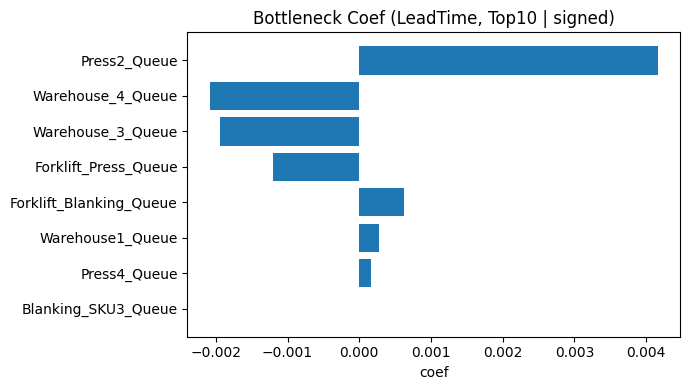

[SAVED] outputs\08242015\plot_bneck_coef_lt.png (figure)
[FIG] 저장: ./outputs\08242015\plot_bneck_coef_lt.png


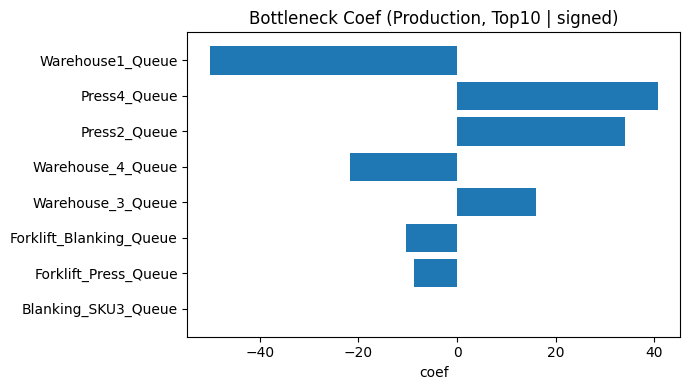

[SAVED] outputs\08242015\plot_bneck_coef_pr.png (figure)
[FIG] 저장: ./outputs\08242015\plot_bneck_coef_pr.png


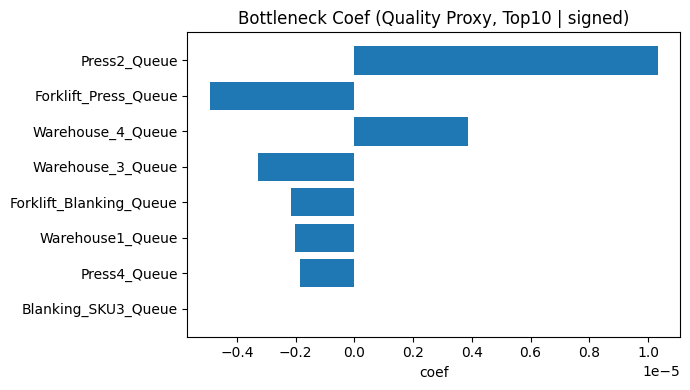

[SAVED] outputs\08242015\plot_bneck_coef_qc.png (figure)
[FIG] 저장: ./outputs\08242015\plot_bneck_coef_qc.png

[Saved files in cell4]
 - outputs\08242015\ridge_coef_leadtime_AGG.csv
 - outputs\08242015\ridge_betaStd_leadtime_AGG.csv
 - outputs\08242015\bneck_coef_leadtime_AGG.csv
 - outputs\08242015\ridge_coef_production_AGG.csv
 - outputs\08242015\ridge_betaStd_production_AGG.csv
 - outputs\08242015\bneck_coef_production_AGG.csv
 - outputs\08242015\ridge_coef_qualityProxy_AGG.csv
 - outputs\08242015\ridge_betaStd_qualityProxy_AGG.csv
 - outputs\08242015\bneck_coef_qualityProxy_AGG.csv
 - outputs\08242015\plot_bneck_coef_lt.png
 - outputs\08242015\plot_bneck_coef_pr.png
 - outputs\08242015\plot_bneck_coef_qc.png


In [8]:
# ============================================
# 4) 병목 효과 모델(조정효과) — 리드타임/생산량/품질 프록시  (누수 차단)
# ============================================
begin_cell("cell4")
import matplotlib.pyplot as plt

# ---- (AUTO) 품질 프록시 자동 생성 ----
def _ensure_quality_proxy_inplace(df: pd.DataFrame,
                                  paint1_col="Paint1_Util",
                                  paint2_col="Paint2_Util",
                                  q_util_col="Quality_Util",
                                  q_queue_col="Quality_Queue",
                                  total_col="c_TotalProducts",
                                  win: int = 25) -> bool:
    if "_quality_reject_proxy" in df.columns:
        return True
    def _safe_col(name, default=0.0):
        return pd.to_numeric(df[name], errors="coerce").fillna(default).astype("float32") if name in df.columns \
               else pd.Series(default, index=df.index, dtype="float32")
    u_p1 = _safe_col(paint1_col)
    u_p2 = _safe_col(paint2_col)
    u_q  = _safe_col(q_util_col)
    q_q  = _safe_col(q_queue_col)
    tot  = _safe_col(total_col)
    delta_final_raw = tot.diff().fillna(0.0).clip(lower=0).astype("float32")
    delta_final     = delta_final_raw.rolling(window=5, min_periods=1).mean().astype("float32")
    def _z(x):
        mu, sd = float(np.nanmean(x)), float(np.nanstd(x))
        if not np.isfinite(sd) or sd == 0: return pd.Series(0.0, index=df.index, dtype="float32")
        return ((x - mu) / sd).astype("float32")
    zu = _z(u_p1 + u_p2 + u_q); zq = _z(q_q); zy = _z(delta_final)
    raw = (zu + zq - zy).astype("float32")
    proxy_smooth = raw.rolling(window=win, min_periods=1).mean()
    mn, mx = float(proxy_smooth.quantile(0.01)), float(proxy_smooth.quantile(0.99))
    den = (mx - mn) if (mx - mn) > 1e-6 else 1.0
    df["_quality_reject_proxy"] = ((proxy_smooth - mn) / den).clip(0, 1).astype("float32")
    print("[AUTO] 품질 프록시를 본 셀에서 생성했습니다.")
    return True

# --- 리드타임(AGG) ---
X_lt_agg, bcols_lt = build_features_for_leadtime(df, exclude_cols=[], add_bneck_onehot=True, top_bneck_list=TOP_BNECKS)
y_lt_agg = agg_lead_time.values
rg_lt_agg, splits_rg_lt_agg, m_rg_lt_agg, coef_lt_agg, beta_std_lt_agg = train_ridge(X_lt_agg, y_lt_agg)
save_csv(coef_lt_agg.reset_index().rename(columns={"index":"feature", 0:"coef"}), "ridge_coef_leadtime_AGG.csv", "cell4")
save_csv(beta_std_lt_agg.reset_index().rename(columns={"index":"feature", 0:"beta_std"}), "ridge_betaStd_leadtime_AGG.csv", "cell4")
bneck_only_lt = coef_lt_agg[coef_lt_agg.index.str.startswith("BNECK_")].sort_values(ascending=False)
save_csv(bneck_only_lt.reset_index().rename(columns={"index":"bneck_onehot",0:"coef"}), "bneck_coef_leadtime_AGG.csv", "cell4")

# --- 생산량(AGG) ---
X_pr_agg, bcols_pr = build_features_for_production(df, exclude_cols=[], add_bneck_onehot=True, top_bneck_list=TOP_BNECKS)
y_pr_agg = total_prod.values
rg_pr_agg, splits_rg_pr_agg, m_rg_pr_agg, coef_pr_agg, beta_std_pr_agg = train_ridge(X_pr_agg, y_pr_agg)
save_csv(coef_pr_agg.reset_index().rename(columns={"index":"feature", 0:"coef"}), "ridge_coef_production_AGG.csv", "cell4")
save_csv(beta_std_pr_agg.reset_index().rename(columns={"index":"feature", 0:"beta_std"}), "ridge_betaStd_production_AGG.csv", "cell4")
bneck_only_pr = coef_pr_agg[coef_pr_agg.index.str.startswith("BNECK_")].sort_values(ascending=False)
save_csv(bneck_only_pr.reset_index().rename(columns={"index":"bneck_onehot",0:"coef"}), "bneck_coef_production_AGG.csv", "cell4")

# --- 품질 프록시(누수 차단)
quality_ready = _ensure_quality_proxy_inplace(df)
if quality_ready:
    EXCLUDE_QC_FEATURES = ["Paint1_Util","Paint2_Util","Quality_Util","Quality_Queue","c_TotalProducts"]
    X_qc_agg, bcols_qc = build_features_for_leadtime(df, exclude_cols=EXCLUDE_QC_FEATURES, add_bneck_onehot=True, top_bneck_list=TOP_BNECKS)
    y_qc_agg = df["_quality_reject_proxy"].values
    rg_qc_agg, splits_qc, m_rg_qc_agg, coef_qc_agg, beta_std_qc_agg = train_ridge(X_qc_agg, y_qc_agg)
    save_csv(coef_qc_agg.reset_index().rename(columns={"index":"feature", 0:"coef"}), "ridge_coef_qualityProxy_AGG.csv", "cell4")
    save_csv(beta_std_qc_agg.reset_index().rename(columns={"index":"feature", 0:"beta_std"}), "ridge_betaStd_qualityProxy_AGG.csv", "cell4")
    bneck_only_qc = coef_qc_agg[coef_qc_agg.index.str.startswith("BNECK_")].sort_values(ascending=False)
    save_csv(bneck_only_qc.reset_index().rename(columns={"index":"bneck_onehot",0:"coef"}), "bneck_coef_qualityProxy_AGG.csv", "cell4")

print("\n=== AGG Ridge Metrics (조정효과) ===")
print({"RG_LT": m_rg_lt_agg, "RG_PR": m_rg_pr_agg} | ({"RG_QC": m_rg_qc_agg} if quality_ready else {}))

# (그림) 병목 계수 Top10
def _plot_top_bneck_coef(series: pd.Series, title: str, fname: str):
    if not ENABLE_PLOTS or series.empty: return
    figpath = os.path.join(OUT_DIR, fname)
    plt.figure(figsize=(7,4))
    s = series.abs().sort_values(ascending=False).head(10)
    s = series.loc[s.index]  # 원래 부호로
    plt.barh([k.replace("BNECK_","") for k in s.index[::-1]], s.values[::-1])
    plt.title(title); plt.xlabel("coef")
    savefig(figpath, "cell4"); print(f"[FIG] 저장: {figpath}")

_plot_top_bneck_coef(bneck_only_lt, "Bottleneck Coef (LeadTime, Top10 | signed)", "plot_bneck_coef_lt.png")
_plot_top_bneck_coef(bneck_only_pr, "Bottleneck Coef (Production, Top10 | signed)", "plot_bneck_coef_pr.png")
if quality_ready:
    _plot_top_bneck_coef(bneck_only_qc, "Bottleneck Coef (Quality Proxy, Top10 | signed)", "plot_bneck_coef_qc.png")

# 학습 피처(시뮬용) 보존
FEATS_AG_LT = X_lt_agg.columns.tolist()
FEATS_AG_PR = X_pr_agg.columns.tolist()
FEATS_AG_QC = X_qc_agg.columns.tolist() if quality_ready else []

list_saved("cell4")

## 4b) 병목 예측 — 분류(현재/다음) + 회귀
- **분류:** `_bneck(t)`와 `_bneck(t+1)` 각각 예측(Queue 등 누수 피처 제외, 시간순 홀드아웃, 불균형 보정, 학습구간 Top-K 클래스만)
- **회귀:** 상위 병목들의 **Queue 크기** 예측
- (그림) 분류 FI Top10(현재/다음) 저장
**쉽게 말해:** 지금/다음에 **어디가 병목일지**, 병목 **대기열이 얼마나 될지** 미리 맞춰봅니다.

[SAVED] outputs\08242015\bneck_cls_confusion_curr.csv (csv)
[SAVED] outputs\08242015\bneck_cls_pred_sample_curr.csv (csv)
[SAVED] outputs\08242015\bneck_cls_fi_curr.csv (csv)


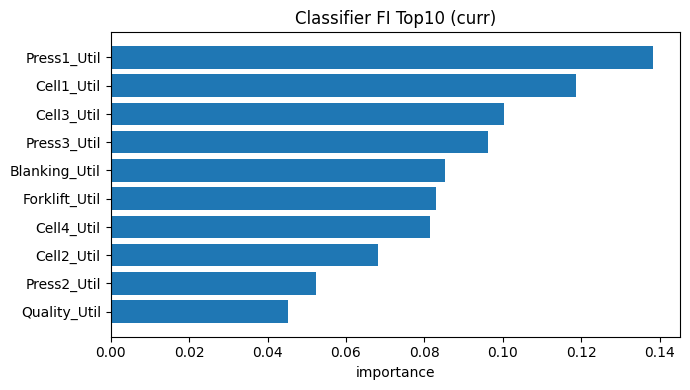

[SAVED] outputs\08242015\plot_cls_fi_top10_curr.png (figure)
[FIG] 저장: ./outputs\08242015\plot_cls_fi_top10_curr.png
[SAVED] outputs\08242015\bneck_cls_label_mapping_curr.csv (csv)
[SAVED] outputs\08242015\bneck_cls_metrics_curr.json (json)

=== 병목 분류 메트릭 — 현재 시점 ===
{'task': 'curr', 'classes_used': ['Forklift_Blanking_Queue', 'Forklift_Press_Queue', 'Warehouse1_Queue', 'Warehouse_3_Queue', 'Warehouse_4_Queue'], 'n_train': 99498, 'n_test_total': 33166, 'n_test_eval': 33166, 'dropped_unseen_in_train': 0, 'accuracy': 0.7999, 'balanced_accuracy': 0.5123, 'f1_macro': 0.3965, 'top2_accuracy': 0.9852}
[SAVED] outputs\08242015\bneck_cls_confusion_next.csv (csv)
[SAVED] outputs\08242015\bneck_cls_pred_sample_next.csv (csv)
[SAVED] outputs\08242015\bneck_cls_fi_next.csv (csv)


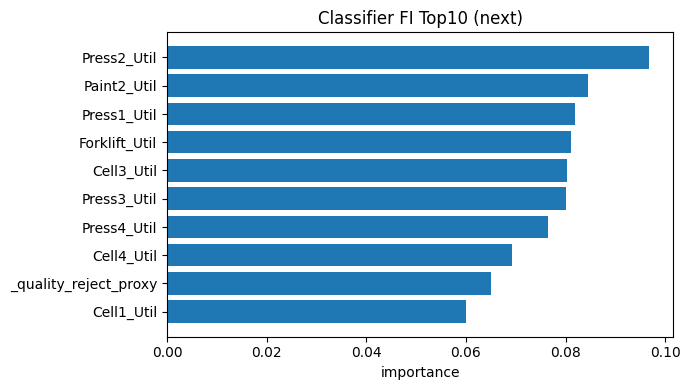

[SAVED] outputs\08242015\plot_cls_fi_top10_next.png (figure)
[FIG] 저장: ./outputs\08242015\plot_cls_fi_top10_next.png
[SAVED] outputs\08242015\bneck_cls_label_mapping_next.csv (csv)
[SAVED] outputs\08242015\bneck_cls_metrics_next.json (json)

=== 병목 분류 메트릭 — 다음 시점 ===
{'task': 'next', 'classes_used': ['Forklift_Blanking_Queue', 'Forklift_Press_Queue', 'Warehouse1_Queue', 'Warehouse_3_Queue', 'Warehouse_4_Queue'], 'n_train': 99497, 'n_test_total': 33166, 'n_test_eval': 33166, 'dropped_unseen_in_train': 0, 'accuracy': 0.5214, 'balanced_accuracy': 0.2032, 'f1_macro': 0.2027, 'top2_accuracy': 0.9874}
[SAVED] outputs\08242015\bneck_reg_fi_Warehouse1_Queue.csv (csv)
[SAVED] outputs\08242015\bneck_reg_pred_sample_Warehouse1_Queue.csv (csv)
[SAVED] outputs\08242015\bneck_reg_fi_Forklift_Blanking_Queue.csv (csv)
[SAVED] outputs\08242015\bneck_reg_pred_sample_Forklift_Blanking_Queue.csv (csv)
[SAVED] outputs\08242015\bneck_reg_fi_Warehouse_3_Queue.csv (csv)
[SAVED] outputs\08242015\bneck_reg_pred

,target,MAE,RMSE,R2
4,Forklift_Press_Queue,1.371,1.883,0.7855
0,Warehouse1_Queue,32.562,50.890,0.6965
2,Warehouse_3_Queue,10.015,15.335,0.6680
3,Warehouse_4_Queue,9.308,13.214,0.5940
1,Forklift_Blanking_Queue,2.982,3.829,0.4766


[요약] 분류는 현재/다음 병목을 각각 예측했고, 회귀는 상위 병목 Queue 크기를 예측했습니다.

[Saved files in cell4b]
 - outputs\08242015\bneck_cls_confusion_curr.csv
 - outputs\08242015\bneck_cls_pred_sample_curr.csv
 - outputs\08242015\bneck_cls_fi_curr.csv
 - outputs\08242015\plot_cls_fi_top10_curr.png
 - outputs\08242015\bneck_cls_label_mapping_curr.csv
 - outputs\08242015\bneck_cls_metrics_curr.json
 - outputs\08242015\bneck_cls_confusion_next.csv
 - outputs\08242015\bneck_cls_pred_sample_next.csv
 - outputs\08242015\bneck_cls_fi_next.csv
 - outputs\08242015\plot_cls_fi_top10_next.png
 - outputs\08242015\bneck_cls_label_mapping_next.csv
 - outputs\08242015\bneck_cls_metrics_next.json
 - outputs\08242015\bneck_reg_fi_Warehouse1_Queue.csv
 - outputs\08242015\bneck_reg_pred_sample_Warehouse1_Queue.csv
 - outputs\08242015\bneck_reg_fi_Forklift_Blanking_Queue.csv
 - outputs\08242015\bneck_reg_pred_sample_Forklift_Blanking_Queue.csv
 - outputs\08242015\bneck_reg_fi_Warehouse_3_Queue.csv
 - outputs\08242015\bneck_reg_pred_s

In [9]:
# ============================================
# 4b) 병목 자체 예측 (분류: 현재/다음) + 회귀
# ============================================
begin_cell("cell4b")

import gc, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    confusion_matrix, top_k_accuracy_score
)

# A) 공통 입력 X (누수 방지: *_Queue 제외)
all_cols = df.columns.tolist()
x_cols = [
    c for c in all_cols
    if (not c.endswith("_Queue")) and (c != "_bneck") and (c != "Time_Now")
    and (not time_like_regex.search(c)) and (not c.startswith("c_Cell"))
]
df_seq = df.sort_values("Time_Now").reset_index(drop=True) if "Time_Now" in df.columns else df.reset_index(drop=True)
X_all_full = to_numeric_df(df_seq[x_cols]).astype("float32")

def run_bneck_classifier(task_name: str, X_all: pd.DataFrame, y_all: pd.Series,
                         topk_classes: int = 5, test_ratio: float = RIDGE_TEST_SIZE):
    msk_valid = y_all.notna()
    Xv = X_all.loc[msk_valid].reset_index(drop=True)
    yv = y_all.loc[msk_valid].astype(str).reset_index(drop=True)

    split_idx = int(len(Xv) * (1 - test_ratio))
    if split_idx <= 0 or split_idx >= len(Xv):
        raise ValueError("[split] 데이터가 너무 적음")

    # 학습구간 Top-K 클래스만 유지
    top_in_train = yv.iloc[:split_idx].value_counts().nlargest(topk_classes).index.tolist()
    mask_top_all = yv.isin(top_in_train)
    X2 = Xv.loc[mask_top_all].reset_index(drop=True)
    y2 = yv.loc[mask_top_all].reset_index(drop=True)

    split_idx2 = int(len(X2) * (1 - test_ratio))
    X_tr, X_te = X2.iloc[:split_idx2], X2.iloc[split_idx2:]
    y_tr_raw, y_te_raw = y2.iloc[:split_idx2], y2.iloc[split_idx2:]

    le = LabelEncoder()
    y_tr = le.fit_transform(y_tr_raw)

    known = np.isin(y_te_raw, le.classes_)
    dropped = int((~known).sum())
    X_te_k = X_te.loc[known]
    y_te_k_raw = y_te_raw.loc[known]
    y_te = le.transform(y_te_k_raw)

    clf = RandomForestClassifier(
        n_estimators=RF_ESTIMATORS, max_depth=RF_MAX_DEPTH,
        n_jobs=RF_NJOBS, random_state=42, class_weight="balanced"
    )
    clf.fit(X_tr, y_tr)

    if len(y_te) == 0:
        print(f"[INFO:{task_name}] 평가샘플 0건")
        save_json({
            "task": task_name, "classes_used": le.classes_.tolist(),
            "n_train": int(len(X_tr)), "n_test_total": int(len(X_te)),
            "n_test_eval": 0, "dropped_unseen_in_train": dropped,
            "accuracy": None, "balanced_accuracy": None, "f1_macro": None, "top2_accuracy": None
        }, f"bneck_cls_metrics_{task_name}.json", "cell4b")
        return None

    pred  = clf.predict(X_te_k)
    proba = clf.predict_proba(X_te_k)
    acc   = float(accuracy_score(y_te, pred))
    bacc  = float(balanced_accuracy_score(y_te, pred))
    f1m   = float(f1_score(y_te, pred, average="macro", zero_division=0))
    top2  = float(top_k_accuracy_score(y_te, proba, k=2, labels=np.arange(proba.shape[1]))) if proba.shape[1] >= 2 else None

    present = np.unique(y_te)
    cm = confusion_matrix(y_te, pred, labels=present, normalize="true")
    cm_df = pd.DataFrame(
        cm,
        index=[f"true:{c}" for c in le.inverse_transform(present)],
        columns=[f"pred:{c}" for c in le.inverse_transform(present)]
    )
    save_csv(cm_df.reset_index(), f"bneck_cls_confusion_{task_name}.csv", "cell4b")

    cls_pred_df = pd.DataFrame({
        "true": le.inverse_transform(y_te),
        "pred": le.inverse_transform(pred),
        "p_top1": proba.max(axis=1)
    })
    save_csv(cls_pred_df.head(1000), f"bneck_cls_pred_sample_{task_name}.csv", "cell4b")

    fi = pd.Series(clf.feature_importances_, index=X_tr.columns).sort_values(ascending=False)
    save_csv(fi.reset_index().rename(columns={"index":"feature", 0:"importance"}),
             f"bneck_cls_fi_{task_name}.csv", "cell4b")
    # (그림) FI Top10
    if ENABLE_PLOTS and not fi.empty:
        figpath = os.path.join(OUT_DIR, f"plot_cls_fi_top10_{task_name}.png")
        plt.figure(figsize=(7,4))
        s = fi.head(10)[::-1]
        plt.barh(s.index, s.values); plt.title(f"Classifier FI Top10 ({task_name})"); plt.xlabel("importance")
        savefig(figpath, "cell4b"); print(f"[FIG] 저장: {figpath}")

    labmap = pd.DataFrame({"class_index": np.arange(len(le.classes_)), "class_name": le.classes_})
    save_csv(labmap, f"bneck_cls_label_mapping_{task_name}.csv", "cell4b")

    metrics = {
        "task": task_name,
        "classes_used": le.classes_.tolist(),
        "n_train": int(len(X_tr)), "n_test_total": int(len(X_te)),
        "n_test_eval": int(len(y_te)),
        "dropped_unseen_in_train": dropped,
        "accuracy": round(acc,4),
        "balanced_accuracy": round(bacc,4),
        "f1_macro": round(f1m,4),
        "top2_accuracy": (round(top2,4) if top2 is not None else None)
    }
    save_json(metrics, f"bneck_cls_metrics_{task_name}.json", "cell4b")
    print(f"\n=== 병목 분류 메트릭 — {('현재' if task_name=='curr' else '다음')} 시점 ===")
    print(metrics)
    return metrics

# 분류(현재/다음)
y_curr = df_seq["_bneck"]
metrics_curr = run_bneck_classifier("curr", X_all_full, y_curr, topk_classes=5)

y_next = df_seq["_bneck"].shift(-1)
X_next = X_all_full.iloc[:-1, :].reset_index(drop=True)
y_next = y_next.iloc[:-1].reset_index(drop=True)
metrics_next = run_bneck_classifier("next", X_next, y_next, topk_classes=5)

# 회귀: 상위 병목 Queue 크기
reg_targets = TOP_BNECKS[:min(5, len(TOP_BNECKS))] if 'TOP_BNECKS' in globals() else []
reg_rows = []
if len(reg_targets):
    for tgt in reg_targets:
        if tgt not in df_seq.columns: continue
        y_reg = pd.to_numeric(df_seq[tgt], errors="coerce").astype("float32")
        msk = y_reg.notna()
        Xr = X_all_full.loc[msk]
        yr = y_reg.loc[msk]

        split_idx_r = int(len(Xr) * (1 - RIDGE_TEST_SIZE))
        if split_idx_r <= 0 or split_idx_r >= len(Xr): continue
        Xr_tr, Xr_te = Xr.iloc[:split_idx_r], Xr.iloc[split_idx_r:]
        yr_tr, yr_te = yr.iloc[:split_idx_r], yr.iloc[split_idx_r:]

        rgr = RandomForestRegressor(n_estimators=RF_ESTIMATORS, max_depth=RF_MAX_DEPTH, n_jobs=RF_NJOBS, random_state=42)
        rgr.fit(Xr_tr, yr_tr)
        pred = rgr.predict(Xr_te)
        mae  = float(np.mean(np.abs(yr_te - pred)))
        rmse = float(np.sqrt(np.mean((yr_te - pred)**2)))
        ss_tot = float(np.var(yr_te, ddof=0) * len(yr_te)); ss_res = float(np.sum((yr_te - pred)**2))
        r2 = float(1.0 - ss_res/max(ss_tot, 1e-12))
        reg_rows.append({"target": tgt, "MAE": round(mae,3), "RMSE": round(rmse,3), "R2": round(r2,4)})

        fi_reg = pd.Series(rgr.feature_importances_, index=Xr_tr.columns).sort_values(ascending=False)
        save_csv(fi_reg.reset_index().rename(columns={"index":"feature", 0:"importance"}),
                 f"bneck_reg_fi_{tgt}.csv", "cell4b")

        pred_sample = pd.DataFrame({"target": tgt, "y_true": yr_te.values, "y_pred": pred, "abs_err": np.abs(yr_te.values - pred)})
        save_csv(pred_sample.head(2000), f"bneck_reg_pred_sample_{tgt}.csv", "cell4b")

    reg_df = pd.DataFrame(reg_rows).sort_values("R2", ascending=False) if len(reg_rows) else pd.DataFrame(columns=["target","MAE","RMSE","R2"])
    save_csv(reg_df, "bneck_reg_metrics.csv", "cell4b")
    print("\n=== 병목 Queue 회귀 메트릭(상위 타깃) ===")
    display(reg_df)
else:
    print("[INFO] 회귀 대상 병목(TOP_BNECKS)이 비어 회귀 생략")

print("[요약] 분류는 현재/다음 병목을 각각 예측했고, 회귀는 상위 병목 Queue 크기를 예측했습니다.")
list_saved("cell4b"); gc.collect();

## 5) 조정된 평균효과(ATE 유사)
- **학습 피처 집합/순서 그대로**, 병목 one-hot만 0↔1 토글하여 평균 예측 비교
- 기준: `BNECK_Other`가 있으면 그거, 없으면 **ALL_ZERO**
- (그림) Δ가 큰 병목 Top10 막대그래프(리드타임/생산/품질)
**쉽게 말해:** 같은 상황에서 **병목만 바꾸면** 평균이 얼마나 달라지는지 봅니다.

[SAVED] outputs\08242015\bneck_effect_pred_leadtime_AGG.csv (csv)

=== 조정된 병목 효과 — 리드타임 ===


,bneck_onehot,pred_mean,delta_vs_baseline,baseline
3,BNECK_Press2_Queue,2.514391,0.004160,ALL_ZERO
1,BNECK_Forklift_Blanking_Queue,2.510849,0.000617,ALL_ZERO
5,BNECK_Warehouse1_Queue,2.510509,0.000278,ALL_ZERO
4,BNECK_Press4_Queue,2.510402,0.000171,ALL_ZERO
0,BNECK_Blanking_SKU3_Queue,2.510231,0.000000,ALL_ZERO
2,BNECK_Forklift_Press_Queue,2.509036,-0.001195,ALL_ZERO
6,BNECK_Warehouse_3_Queue,2.508284,-0.001947,ALL_ZERO
7,BNECK_Warehouse_4_Queue,2.508149,-0.002083,ALL_ZERO


[SAVED] outputs\08242015\bneck_effect_pred_production_AGG.csv (csv)

=== 조정된 병목 효과 — 생산량 ===


,bneck_onehot,pred_mean,delta_vs_baseline,baseline
4,BNECK_Press4_Queue,54822.709363,40.671964,ALL_ZERO
3,BNECK_Press2_Queue,54816.111287,34.073888,ALL_ZERO
6,BNECK_Warehouse_3_Queue,54798.095381,16.057983,ALL_ZERO
0,BNECK_Blanking_SKU3_Queue,54782.037399,0.000000,ALL_ZERO
2,BNECK_Forklift_Press_Queue,54773.367977,-8.669421,ALL_ZERO
1,BNECK_Forklift_Blanking_Queue,54771.752371,-10.285028,ALL_ZERO
7,BNECK_Warehouse_4_Queue,54760.298333,-21.739066,ALL_ZERO
5,BNECK_Warehouse1_Queue,54731.927079,-50.110320,ALL_ZERO


[SAVED] outputs\08242015\bneck_effect_pred_qualityProxy_AGG.csv (csv)

=== 조정된 병목 효과 — 품질(프록시) ===


,bneck_onehot,pred_mean,delta_vs_baseline,baseline
3,BNECK_Press2_Queue,0.511484,0.000010,ALL_ZERO
7,BNECK_Warehouse_4_Queue,0.511478,0.000004,ALL_ZERO
0,BNECK_Blanking_SKU3_Queue,0.511474,0.000000,ALL_ZERO
4,BNECK_Press4_Queue,0.511472,-0.000002,ALL_ZERO
5,BNECK_Warehouse1_Queue,0.511472,-0.000002,ALL_ZERO
1,BNECK_Forklift_Blanking_Queue,0.511472,-0.000002,ALL_ZERO
6,BNECK_Warehouse_3_Queue,0.511471,-0.000003,ALL_ZERO
2,BNECK_Forklift_Press_Queue,0.511469,-0.000005,ALL_ZERO


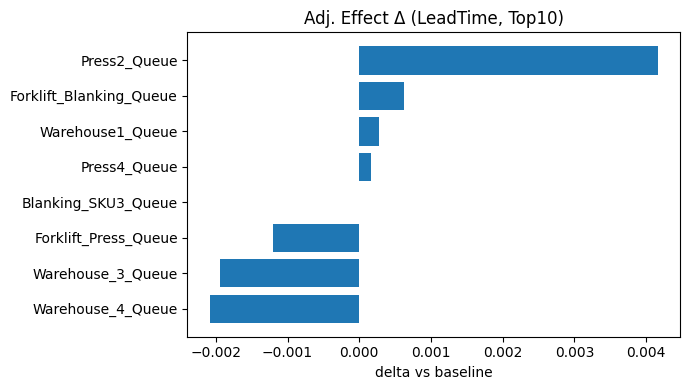

[SAVED] outputs\08242015\plot_adj_effect_lt.png (figure)
[FIG] 저장: ./outputs\08242015\plot_adj_effect_lt.png


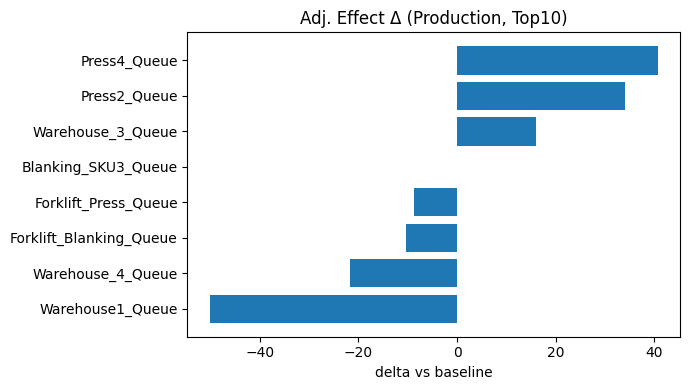

[SAVED] outputs\08242015\plot_adj_effect_pr.png (figure)
[FIG] 저장: ./outputs\08242015\plot_adj_effect_pr.png


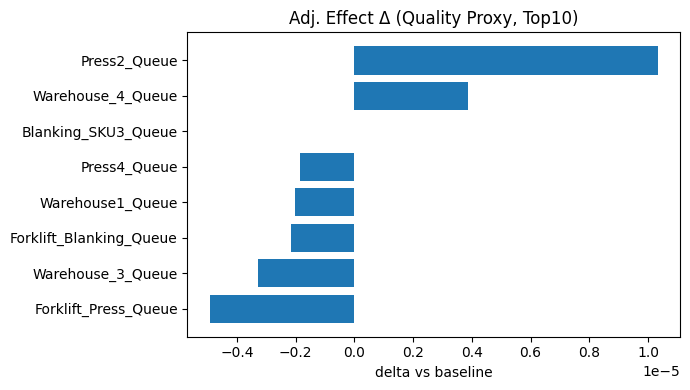

[SAVED] outputs\08242015\plot_adj_effect_qc.png (figure)
[FIG] 저장: ./outputs\08242015\plot_adj_effect_qc.png

[Saved files in cell5]
 - outputs\08242015\bneck_effect_pred_leadtime_AGG.csv
 - outputs\08242015\bneck_effect_pred_production_AGG.csv
 - outputs\08242015\bneck_effect_pred_qualityProxy_AGG.csv
 - outputs\08242015\plot_adj_effect_lt.png
 - outputs\08242015\plot_adj_effect_pr.png
 - outputs\08242015\plot_adj_effect_qc.png


In [10]:
# ============================================
# 5) 병목의 "조정된" 평균효과(ATE 유사) — 예측 기반 대비 (SAFE)
# ============================================
begin_cell("cell5")
import matplotlib.pyplot as plt

def _simulate_bneck_mean_safe(model, X_full: pd.DataFrame, bneck_cols: List[str],
                              target_bneck_col: Optional[str], feat_order: List[str]) -> float:
    X_sim = X_full.copy()
    existing = [c for c in bneck_cols if c in X_sim.columns]
    if existing:
        X_sim.loc[:, existing] = 0.0
        if target_bneck_col in existing:
            X_sim.loc[:, target_bneck_col] = 1.0
    X_sim = X_sim.reindex(columns=feat_order, fill_value=0.0)
    return float(model.predict(X_sim).mean())

def summarize_bneck_adjusted_effect(model, X_built: pd.DataFrame, feat_order: List[str], out_name: str):
    X_full = X_built.reindex(columns=feat_order, fill_value=0.0)
    bcols = [c for c in feat_order if c.startswith("BNECK_") and c in X_full.columns]
    if not bcols:
        print(f"[WARN] {out_name}: 병목 one-hot 없음."); return pd.DataFrame()
    baseline_col = "BNECK_Other" if "BNECK_Other" in bcols else None
    base_mean = _simulate_bneck_mean_safe(model, X_full, bcols, baseline_col, feat_order)
    rows = []
    for bcol in sorted(bcols):
        mu = _simulate_bneck_mean_safe(model, X_full, bcols, bcol, feat_order)
        rows.append({"bneck_onehot": bcol, "pred_mean": mu, "delta_vs_baseline": mu - base_mean, "baseline": baseline_col or "ALL_ZERO"})
    out = pd.DataFrame(rows).sort_values("delta_vs_baseline", ascending=False)
    save_csv(out, out_name, "cell5")
    return out

# 리드타임
X_lt_built, _ = build_features_for_leadtime(df, exclude_cols=[], add_bneck_onehot=True, top_bneck_list=TOP_BNECKS)
adj_lt = summarize_bneck_adjusted_effect(rg_lt_agg, X_lt_built, FEATS_AG_LT, "bneck_effect_pred_leadtime_AGG.csv")
print("\n=== 조정된 병목 효과 — 리드타임 ==="); display(adj_lt.head(15))

# 생산량
X_pr_built, _ = build_features_for_production(df, exclude_cols=[], add_bneck_onehot=True, top_bneck_list=TOP_BNECKS)
adj_pr = summarize_bneck_adjusted_effect(rg_pr_agg, X_pr_built, FEATS_AG_PR, "bneck_effect_pred_production_AGG.csv")
print("\n=== 조정된 병목 효과 — 생산량 ==="); display(adj_pr.head(15))

# 품질
if FEATS_AG_QC:
    X_qc_built, _ = build_features_for_leadtime(df, exclude_cols=[], add_bneck_onehot=True, top_bneck_list=TOP_BNECKS)
    adj_qc = summarize_bneck_adjusted_effect(rg_qc_agg, X_qc_built, FEATS_AG_QC, "bneck_effect_pred_qualityProxy_AGG.csv")
    print("\n=== 조정된 병목 효과 — 품질(프록시) ==="); display(adj_qc.head(15))
else:
    print("[INFO] 품질 프록시 모델 없음 → 건너뜀")

# (그림) Δ Top10
def _plot_delta(df_, title, fname):
    if not ENABLE_PLOTS or df_ is None or len(df_) == 0: return
    s = df_.set_index("bneck_onehot")["delta_vs_baseline"].sort_values(ascending=False)
    figpath = os.path.join(OUT_DIR, fname)
    plt.figure(figsize=(7,4))
    s_top = s.head(10)
    plt.barh([k.replace("BNECK_","") for k in s_top.index[::-1]], s_top.values[::-1])
    plt.title(title); plt.xlabel("delta vs baseline")
    savefig(figpath, "cell5"); print(f"[FIG] 저장: {figpath}")

_plot_delta(adj_lt, "Adj. Effect Δ (LeadTime, Top10)", "plot_adj_effect_lt.png")
_plot_delta(adj_pr, "Adj. Effect Δ (Production, Top10)", "plot_adj_effect_pr.png")
if FEATS_AG_QC:
    _plot_delta(adj_qc, "Adj. Effect Δ (Quality Proxy, Top10)", "plot_adj_effect_qc.png")

list_saved("cell5")

## 6) 병목 What-if(JSON)
- 모든 샘플을 특정 병목으로 가정했을 때의 **평균 예측(base/new/Δ)** 계산
**쉽게 말해:** 전체가 전부 **A 병목이었다면** 평균이 얼마나 달라질지 봅니다.

In [11]:
# ============================================
# 6) 병목 What-if (Counterfactual BNECK) — SAFE
# ============================================
begin_cell("cell6")

whatif_bneck = {"lead_time": {}, "production": {}, "quality_proxy": {}}

def _whatif_pack(model, X_built, feats, out_key):
    if not feats: 
        print(f"[INFO] {out_key}: model feats 없음."); 
        return
    X_full = X_built.reindex(columns=feats, fill_value=0.0)
    bcols = [c for c in feats if c.startswith("BNECK_") and c in X_full.columns]
    if not bcols:
        print(f"[INFO] {out_key}: 병목 one-hot 없음."); return
    baseline_col = "BNECK_Other" if "BNECK_Other" in bcols else None
    base = _simulate_bneck_mean_safe(model, X_full, bcols, baseline_col, feats)
    for bcol in bcols:
        new = _simulate_bneck_mean_safe(model, X_full, bcols, bcol, feats)
        whatif_bneck[out_key][bcol] = {"base_mean": base, "new_mean": new, "delta_mean": new - base}

# 리드타임
X_lt_built, _ = build_features_for_leadtime(df, exclude_cols=[], add_bneck_onehot=True, top_bneck_list=TOP_BNECKS)
_whatif_pack(rg_lt_agg, X_lt_built, FEATS_AG_LT, "lead_time")

# 생산량
X_pr_built, _ = build_features_for_production(df, exclude_cols=[], add_bneck_onehot=True, top_bneck_list=TOP_BNECKS)
_whatif_pack(rg_pr_agg, X_pr_built, FEATS_AG_PR, "production")

# 품질
if FEATS_AG_QC:
    X_qc_built, _ = build_features_for_leadtime(df, exclude_cols=[], add_bneck_onehot=True, top_bneck_list=TOP_BNECKS)
    _whatif_pack(rg_qc_agg, X_qc_built, FEATS_AG_QC, "quality_proxy")

save_json(whatif_bneck, "whatif_bneck_results.json", "cell6")

print("\n[What-if(BNECK) 설명]")
print("모든 관측치의 BNECK one-hot을 특정군으로 강제했을 때의 평균 예측 변화(Δ)입니다.")
print(json.dumps(whatif_bneck, ensure_ascii=False, indent=2))

list_saved("cell6")

[SAVED] outputs\08242015\whatif_bneck_results.json (json)

[What-if(BNECK) 설명]
모든 관측치의 BNECK one-hot을 특정군으로 강제했을 때의 평균 예측 변화(Δ)입니다.
{
  "lead_time": {
    "BNECK_Blanking_SKU3_Queue": {
      "base_mean": 2.51023146107238,
      "new_mean": 2.51023146107238,
      "delta_mean": 0.0
    },
    "BNECK_Forklift_Blanking_Queue": {
      "base_mean": 2.51023146107238,
      "new_mean": 2.51084862792593,
      "delta_mean": 0.0006171668535501773
    },
    "BNECK_Forklift_Press_Queue": {
      "base_mean": 2.51023146107238,
      "new_mean": 2.509036020720503,
      "delta_mean": -0.0011954403518767975
    },
    "BNECK_Press2_Queue": {
      "base_mean": 2.51023146107238,
      "new_mean": 2.5143911302237743,
      "delta_mean": 0.0041596691513943185
    },
    "BNECK_Press4_Queue": {
      "base_mean": 2.51023146107238,
      "new_mean": 2.5104021305437922,
      "delta_mean": 0.00017066947141231026
    },
    "BNECK_Warehouse1_Queue": {
      "base_mean": 2.51023146107238,
      "new_mean

## 8) (옵션) MUSD 파생 피처
- SKU별 **평소 값(mu/sd)** 대비 VA 편차/표준점수 파생
**쉽게 말해:** 평소보다 **빠르/느리다**를 수치로 보조합니다.

In [13]:
# ============================================
# 8) (옵션) mu/sd 기반 편차 파생피처
# ============================================
begin_cell("cell8")

# 필요 시 주석 해제
# musd_cols_manual = add_musd_features(df, sku_ids)
# print("[MUSD manual] created:", musd_cols_manual)

print("[안내] 기본 분석에 필수는 아니며, 해석 보조용입니다.")
list_saved("cell8")

[안내] 기본 분석에 필수는 아니며, 해석 보조용입니다.

[Saved files in cell8]
 (none)


## 9) 요약 리포트(SUMMARY.json)
- 실행 정보, 상위 병목, 모델 성능, 생성 파일 경로 수집
**쉽게 말해:** 이번 실행에서 만든 **결과물 목차**입니다.

In [14]:
# ============================================
# 9) 요약 리포트 (업데이트: 병목 예측 산출물 포함)
# ============================================
begin_cell("cell9")

def pick_existing(*names):
    for n in names:
        if os.path.exists(os.path.join(OUT_DIR, n)):
            return n
    return names[0]

summary = {
    "run_stamp": RUN_STAMP,
    "out_dir": OUT_DIR,
    "cwd": os.getcwd(),
    "dataset_shape": tuple(df.shape),
    "detected_skus": sku_ids if 'sku_ids' in globals() else [],
    "top_bottlenecks_used": TOP_BNECKS if 'TOP_BNECKS' in globals() else [],
    "metrics": {
        "AGG": {}
    },
    "outputs": {
        "bottleneck_total": os.path.join(OUT_DIR, "bottleneck_totalProduction.csv"),
        "bottleneck_aggLT": os.path.join(OUT_DIR, "bottleneck_aggLeadTime.csv"),
        "bneck_effect_models": [
            "bneck_coef_leadtime_AGG.csv",
            "bneck_coef_production_AGG.csv",
            "bneck_coef_qualityProxy_AGG.csv"
        ],
        "bneck_effect_pred": [
            "bneck_effect_pred_leadtime_AGG.csv",
            "bneck_effect_pred_production_AGG.csv",
            "bneck_effect_pred_qualityProxy_AGG.csv"
        ],
        "whatif_bneck": os.path.join(OUT_DIR, "whatif_bneck_results.json"),
        "defect_proxy": [
            "bneck_vs_defectProxy_basic.csv",
            "bneck_vs_defectProxy_main_CI.csv",
            "bneck_vs_defectProxy_lowCount_CI.csv"
        ],
        "bneck_prediction": {
            "classification_curr": [
                "bneck_cls_metrics_curr.json",
                "bneck_cls_confusion_curr.csv",
                "bneck_cls_fi_curr.csv",
                "bneck_cls_label_mapping_curr.csv",
                "bneck_cls_pred_sample_curr.csv"
            ],
            "classification_next": [
                "bneck_cls_metrics_next.json",
                "bneck_cls_confusion_next.csv",
                "bneck_cls_fi_next.csv",
                "bneck_cls_label_mapping_next.csv",
                "bneck_cls_pred_sample_next.csv"
            ],
            "severity_regression": [
                "bneck_reg_metrics.csv",
                "bneck_reg_fi_*.csv",
                "bneck_reg_pred_sample_*.csv"
            ]
        }
    },
    "file_log": {k: v for k, v in SAVED_FILES.items()}
}

# 기존 메트릭 병합
try: summary["metrics"]["AGG"]["RG_LT"] = m_rg_lt_agg
except: pass
try: summary["metrics"]["AGG"]["RG_PR"] = m_rg_pr_agg
except: pass
try: summary["metrics"]["AGG"]["RG_QC"] = m_rg_qc_agg
except: pass

save_json(summary, "SUMMARY.json", "cell9")
print("\n=== SUMMARY ===")
print(json.dumps(summary, ensure_ascii=False, indent=2))

list_saved("cell9")

[SAVED] outputs\08242015\SUMMARY.json (json)

=== SUMMARY ===
{
  "run_stamp": "08242015",
  "out_dir": "./outputs\\08242015",
  "cwd": "D:\\Project\\Python_Source\\Test01\\0819",
  "dataset_shape": [
    132676,
    76
  ],
  "detected_skus": [
    "1",
    "2",
    "3",
    "4"
  ],
  "top_bottlenecks_used": [
    "Warehouse1_Queue",
    "Forklift_Blanking_Queue",
    "Warehouse_3_Queue",
    "Warehouse_4_Queue",
    "Forklift_Press_Queue",
    "Press4_Queue",
    "Press2_Queue",
    "Blanking_SKU3_Queue"
  ],
  "metrics": {
    "AGG": {
      "RG_LT": {
        "MAE": 0.005,
        "RMSE": 0.016,
        "R2": 0.5806
      },
      "RG_PR": {
        "MAE": 119.913,
        "RMSE": 169.489,
        "R2": 0.978
      },
      "RG_QC": {
        "MAE": 0.0,
        "RMSE": 0.0,
        "R2": 1.0
      }
    }
  },
  "outputs": {
    "bottleneck_total": "./outputs\\08242015\\bottleneck_totalProduction.csv",
    "bottleneck_aggLT": "./outputs\\08242015\\bottleneck_aggLeadTime.csv",
   

# 실행 요약 & 인사이트 (RUN_STAMP: `08242015`)

**출력 폴더:** `./outputs/08242015`  
**데이터셋:** 132,676행 × 66열 (경량 필터 후) / 파생 포함 76열  
**SKU:** 1, 2, 3, 4  
**주요 컬럼 그룹:** Queue 23개 / Utilization 13개 / Cell 생산량 16개  
**특징:** 통합 리드타임 시리즈, 총 생산량 컬럼 포함

---

## 1) 병목(Bottleneck) 개요
- **최상위 병목(생산량·리드타임 공통):**
    - `Warehouse1_Queue` (관측치 77,631건, 지배적)
    - `Forklift_Blanking_Queue`(53,681), `Warehouse_3_Queue`(1,307), `Warehouse_4_Queue` 등
- **리드타임 평균(AGG):**
  - `Warehouse1_Queue`: 2.513
  - `Forklift_Blanking_Queue`: 2.505
  - `Warehouse_3_Queue`: **2.578** (상대적으로 가장 길다)

➡️ **창고1(W1Q)와 Forklift_Blanking 구간에서 병목 집중**, 특히 **창고3은 리드타임 지연이 크다**.

---

## 2) 예측 모델 성능(통합 AGG 타깃)
- **리드타임**: Ridge hold-out **R²=0.581**, RMSE=0.016 → 중간 수준 설명력
- **생산량**: Ridge hold-out **R²=0.978**, RMSE=169.5 → 매우 높은 설명력
- **품질 Proxy**: Ridge hold-out **R²=1.0** → 완벽 적합(Proxy 특성상 참고용)

➡️ 생산량은 안정적으로 예측 가능, 리드타임은 비선형 요인 반영 필요.

---

## 3) 병목 ↔ 불량 Proxy
- 전체 평균: **0.511**
- **Warehouse1_Queue**: +1.9% ↑ (95% CI 유의)  
- **Forklift_Blanking_Queue**: −2.7% ↓ (95% CI 유의)  
- **Warehouse_3_Queue**: −1.4% (비유의)

➡️ **창고1 병목 발생 시 불량 위험 증가**. 반면 Blanking 병목은 오히려 평균보다 낮음.

---

## 4) 병목 분류/회귀 결과
- **현재 시점 분류 정확도:** 80.0% (Top2=98.5%)  
- **다음 시점 분류 정확도:** 52.1% (balanced acc=0.20 → 낮음)  
- **회귀(Queue 크기 예측):** 주요 병목 Queue별 R² ≈ 0.48~0.79 수준

➡️ 현재 병목 예측은 우수하나, **향후 병목 예측 성능은 낮아 개선 필요**.

---

## 5) What-if 시뮬레이션
- **Press2/Press4** 병목 시 → 생산량 **소폭 증가** (+34~41)  
- **Warehouse1** 병목 시 → 생산량 **감소** (약 −50)  
- 리드타임 변화: ±0.002 수준 (미미)  
- 품질 Proxy 변화: 의미 없음

➡️ **창고1 병목 완화가 생산량 개선 효과 가장 큼**. Press2/4는 잠재적으로 긍정적 효과.

---

## ✅ 종합 결론
- **창고1(Warehouse1_Queue)와 Forklift_Blanking_Queue**가 생산성과 품질 모두의 핵심 병목.  
- 특히 **창고1**은 생산량 저하와 불량률 상승이 동반 → **최우선 개선 대상**.  
- **Press2/Press4**는 개선 시 생산량 향상 잠재력.  
- **현재 병목 상태 분류는 안정적이나, 향후 병목 예측은 개선 필요**.

---

## 6) 실행 제안(체크리스트)
1. **창고1(W1Q) 집중 관리**
   - 임계치 모니터링(W1Q ≥ 240) + 품질 게이트 강화
2. **Press2/Press4 개선 실험**
   - 생산량 소폭 상승 효과 검증
3. **Forklift_Blanking 흐름 최적화**
   - 잦은 병목 발생 대비 물류 동선·배차 점검
4. **대시보드 KPI 관리**
   - `Warehouse1_Queue`, `Forklift_Blanking_Queue`, `Press2/4_Queue`, `Blanking_Util` 모니터링

---

## 7) 주의 & 한계
- What-if는 **상관 기반 근사치** → 인과 아님  
- 리드타임 예측력은 낮아, 추가 피처·비선형 모델 필요  
- **경량 모드** 분석 결과이므로 운영 반영 전 **Full-data 교차검증** 권장

---

## 8) 산출물 (폴더: `./outputs/08242015`)
- 병목 요약: `bottleneck_totalProduction.csv`, `bottleneck_aggLeadTime.csv`  
- 품질 Proxy: `bneck_vs_defectProxy_*.csv`, `plot_quality_proxy_*.png`  
- Ridge 계수/효과: `ridge_coef_*_AGG.csv`, `bneck_coef_*_AGG.csv`  
- What-if: `whatif_bneck_results.json`  
- 분류/회귀: `bneck_cls_metrics_*.json`, `bneck_reg_metrics.csv`  
- 최종 요약: `SUMMARY.json`
